In [1]:
!pip install keras tqdm

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [0]:
data_obj = fetch_olivetti_faces()

X_original = data_obj['data']

#binarize data
X = 1.0 * (X_original > X_original.mean())

y = data_obj['target']

indices = np.arange(len(y))

indices_train, indices_test, y_train, y_test = train_test_split(indices, y, stratify=y, test_size=0.1, random_state=0)

X_train = X[indices_train]
X_test = X[indices_test]

### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{Z}$$

($Z$ is a normalizing factor, $Z = \sum_{u, g}e^{-E(u, g)}$)

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$ and consequently from the definition it follows that $$P(h_i = 1 \mid v) = \frac{1}{1 + exp((vW)_{i})}$$

RBMs are optimized using approximation to likelihood.

$$P(x) = \frac{\sum_{h}P(x, h)}{Z}$$

The algorithm that is used to approximate derivatives of log likelihood is called **contrastive divergence**, see for example [this link](http://deeplearning.net/tutorial/rbm.html).

In [0]:
def probabilities_from_other(W, other):
  """
  Get probabilities from hidden given visible or the other way around
  """
  energy = K.dot(other, W)
  return K.sigmoid(energy)


def sample_bernoulli(probas):
  uniform_samples = K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = probabilities_from_other(W, other)
  return sample_bernoulli(proba)


def free_energy(W, visible):
  return - K.sum(
    K.softplus(K.dot(visible, W)),
    axis=-1
  )


def cd1_variables(W, visible):
  hidden0 = K.identity(
      probabilities_from_other(W, visible),
      name='hidden0')
  
  # suggested at Hinton's course - don't sample, use probabilities
  visible1 = K.identity(
      probabilities_from_other(K.transpose(W), hidden0),
      name='visible1')
  
  return hidden0, visible1


def cd1(W, visible):
  hidden0, visible1 = cd1_variables(W, visible)
  goodness0 = free_energy(W, visible)
  
  # we do this not to mess up gradient computation
  visible1_correct = K.stop_gradient(visible1)
  goodness1 = free_energy(W, visible1_correct)
  
  return K.mean(goodness0 - goodness1)

### Gradient descent methods

In [0]:
def gradient_descent_updates(loss, weights, lr):
  grads = K.gradients(loss, weights)
  return [K.update(weights, weights - lr * grad) for grad in grads]


def momentum_updates(loss, weights, lr, beta):
  grads = K.gradients(loss, weights)
  momentums = [K.variable(np.zeros(weights.shape)) for grad in grads]
  momentum_updates = [
      K.update(momentum, beta * momentum + grad)
      for (momentum, grad) in zip(momentums, grads)
  ]
  weight_updates = [
      K.update(weights, weights - lr * momentum)
      for momentum in momentums
  ]
  return momentum_updates + weight_updates

In [0]:
class RBM:
  
  DEFAULT_LOG_N_EPOCHS = 100
  
  def __init__(self, n_hidden):
    self.n_hidden = n_hidden
    self.trained = False
  
  def fit(
      self,
      X,
      n_epochs,
      validation_split=0,
      learning_rate=2e-3,
      weight_decay=1e-3,
      minibatch_size=16,
      momentum_beta=0.5,
      log_n_epochs=None):
    
    n_visible = X.shape[1]
    self.n_visible = n_visible
    init_std = np.sqrt(self.n_hidden)
    init_weights = np.random.uniform(
        size=(n_visible, self.n_hidden),
        low=-2 / init_std,
        high= 2 / init_std
    )
    self.W_in = K.variable(init_weights)
    self.visible_in = Input(shape=(n_visible,))
    self.cd = cd1(self.W_in, self.visible_in)

    if log_n_epochs is None:
      self.log_n_epochs = RBM.DEFAULT_LOG_N_EPOCHS
    else:
      self.log_n_epochs = log_n_epochs
    if validation_split > 0:
      X_train, X_val = train_test_split(X, test_size=validation_split)
    else:
      X_train, X_val = X, X
    
    loss = self.cd + weight_decay * K.sum(self.W_in ** 2)
    [cd1_gradient] = K.gradients(loss, self.W_in)

    train_op = K.function(
        inputs=[self.visible_in],
        outputs=[self.cd, loss],
        updates=momentum_updates(loss, self.W_in, learning_rate, beta=momentum_beta)
    )
    
    val_op = K.function(
        inputs=[self.visible_in],
        outputs=[self.cd, loss]
    )
    
    _n_batches = int(round(X_train.shape[0] / minibatch_size))
    
    return self._train(X_train, X_val, train_op, val_op, n_epochs, minibatch_size, self.log_n_epochs)
        
  def _train(self, X_train, X_val, train_op, val_op, n_epochs, minibatch_size, log_n_epochs):
    
    self.batches_per_epoch = int(round(X_train.shape[0] / minibatch_size))

    cd_values = []
    loss_values = []
    
    for epoch in range(n_epochs):
      for i in range(self.batches_per_epoch):
        minibatch_indices = np.random.randint(X_train.shape[0], size=minibatch_size)
        minibatch = X_train[minibatch_indices]
        __ = train_op([minibatch])
        [cd_value, loss_value] = val_op([X_val])
        cd_values.append(cd_value)
        loss_values.append(loss_value)
      if epoch % log_n_epochs == 0:
        last_loss_mean = np.mean(loss_values[-log_n_epochs:])
        last_cd_mean = np.mean(cd_values[-log_n_epochs:])

        print("epoch {}: cd={:.2f} loss={:.2f}".format(
            epoch,
            last_cd_mean,
            last_loss_mean)
        )
     
    self.trained = True
    return cd_values, loss_values
  
  def transform(self, X, use_proba=False):
    assert self.trained, 'must train model first'
    if use_proba:
      transforming_function = probabilities_from_other
    else:
      transforming_function = sample_from_other
    return self._transform(X, transforming_function)

  def _transform(self, X, transforming_function):
    tensor = transforming_function(self.W_in, self.visible_in)
    return tensor.eval(feed_dict={self.visible_in: X}, session=K.get_session())
  
  def inverse_transform(self, Y, use_proba=False):
    assert self.trained, 'must train model first'
    if use_proba:
      transforming_function = probabilities_from_other
    else:
      transforming_function = sample_from_other
    return self._inverse_transform(Y, transforming_function)

  def _inverse_transform(self, Y, transforming_function):
    assert self.trained, 'must train model first'
    hidden_input = Input(shape=(self.n_hidden,))
    tensor = transforming_function(
        K.transpose(self.W_in),
        hidden_input
    )
    return tensor.eval(feed_dict={hidden_input: Y}, session=K.get_session())


### RBM class

#### Plotting utils

In [0]:
def show_reconstruction(original, reconstructed, reconstructed_probabilities, howmany=5):
  original_faces = original.reshape(-1, 64, 64)
  reconstructed_faces = reconstructed.reshape(-1, 64, 64)
  reconstructed_probabilities_faces = reconstructed_probabilities.reshape(-1, 64, 64)
  
  for i in range(howmany):
    test_face = original_faces[i]
    reconstructed_face = reconstructed_faces[i]
    reconstructed_proba_face = reconstructed_probabilities_faces[i]
    
    plt.subplot(331)
    plt.imshow(reconstructed_proba_face, cmap='gray')
    plt.title('probabilities')
    plt.axis('off')
    
    plt.subplot(332)
    plt.imshow(test_face, cmap='gray')
    plt.title('original binarized')
    plt.axis('off')
    
    plt.subplot(333)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title('reconstructed binarized')
    plt.axis('off')
    
    plt.show()

    
def plot_history(cd_values, batches_per_epoch, log_n_epochs, alpha=0.1):
  plt.title('Contrastive divergence')
  plt.plot(cd_values, label='cd')
  plt.plot(pd.Series(cd_values).ewm(alpha=alpha).mean(), label='smoothed cd')
  plt.xlabel('epoch')
  plt.ylabel('cd')
  plt.legend()
  plt.xticks(
      np.arange(0,
                len(cd_values),
                step=batches_per_epoch * log_n_epochs
               ),
      np.arange(0,
                len(cd_values) // batches_per_epoch,
                step=log_n_epochs
               )
  )
  plt.show()
  
  
def plot_tiled(images, side_length=10):
  tiled_faces = np.vstack(
    [
        np.hstack(list(images[i*side_length:(i+1)*side_length].reshape(-1, 64, 64)))
        for i in range(side_length)
    ]
  )

  plt.figure(figsize=(16, 10))
  plt.title("""{} 'hidden' faces""".format(side_length **2))
  plt.imshow(tiled_faces, cmap='gray')
  plt.axis('off')
  plt.show()

### RBM setup

In [0]:
rbm = RBM(n_hidden=225)

#### Run training

In [9]:
%%time

cd_values, loss_values = rbm.fit(
    X_train,
    validation_split=0.1,
    weight_decay=0.002,
    n_epochs=250)

epoch 0: cd=-45.70 loss=-34.77
epoch 100: cd=-251.47 loss=-233.75
epoch 200: cd=-249.00 loss=-222.50
CPU times: user 27.1 s, sys: 5.75 s, total: 32.8 s
Wall time: 27.2 s


### Plot training loss

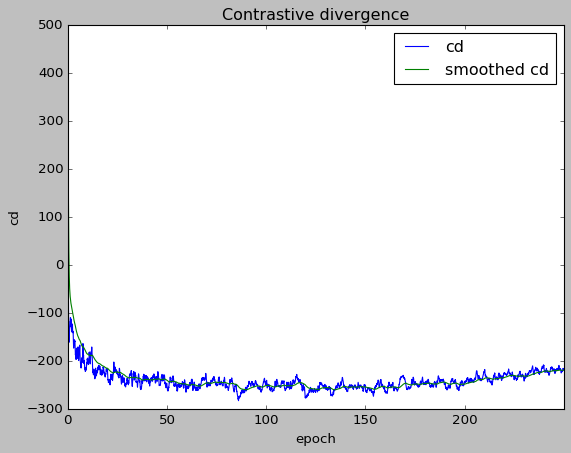

In [10]:
plot_history(cd_values, rbm.batches_per_epoch, alpha=0.01, log_n_epochs=50)

In [11]:
print(K.eval(rbm.W_in))

[[-0.01957228  0.3137779  -0.07190496 ... -0.09729337  0.16979527
  -0.28838468]
 [ 0.1047027   0.20348747 -0.03024339 ... -0.09288359  0.28960806
  -0.10968643]
 [-0.0615437   0.20120591  0.16124237 ... -0.26718968  0.03704103
  -0.15187   ]
 ...
 [ 0.0998367  -0.08735171 -0.25349784 ...  0.13904987 -0.13671117
   0.06875325]
 [-0.03457544 -0.17431091 -0.21820576 ...  0.1763989  -0.11206465
   0.09125067]
 [-0.02377567  0.02796733 -0.24947058 ...  0.18790792 -0.24696903
   0.00652292]]


In [0]:
probabilities_visible_test = rbm.inverse_transform(rbm.transform(X_test, use_proba=True), use_proba=True)
sampled_visible_test = rbm.inverse_transform(rbm.transform(X_test))

In [0]:
probabilities_visible_train = rbm.inverse_transform(rbm.transform(X_train, use_proba=True), use_proba=True)
sampled_visible_train = rbm.inverse_transform(rbm.transform(X_train))

### Show reconstructed faces

#### Reconstructed train faces

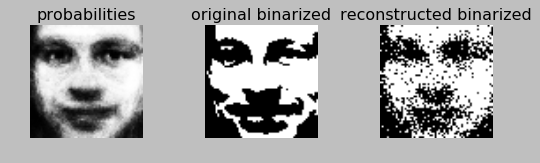

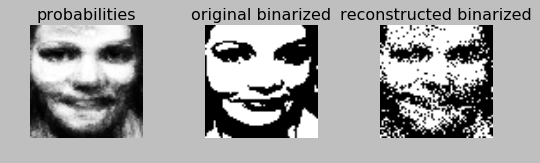

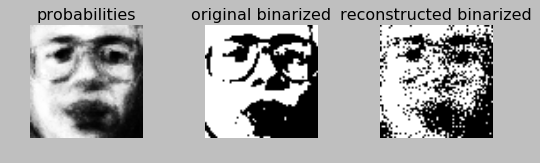

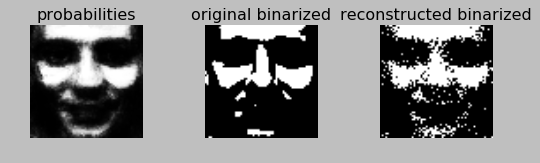

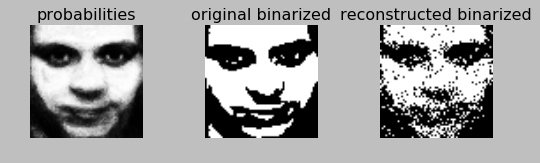

In [14]:
show_reconstruction(
    X_train,
    sampled_visible_train,
    probabilities_visible_train)

#### Reconstructed test faces

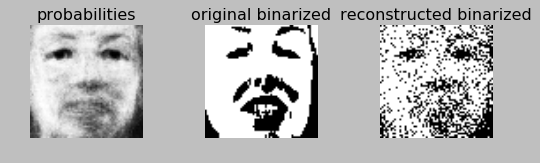

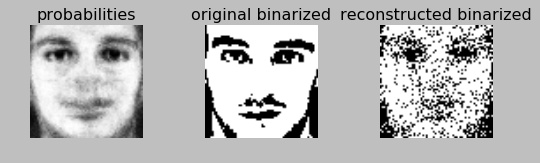

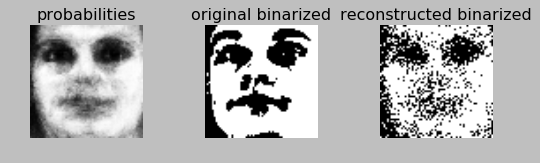

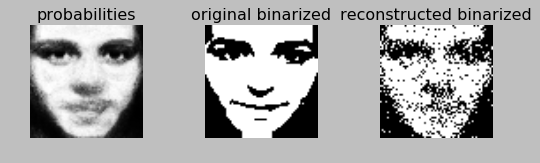

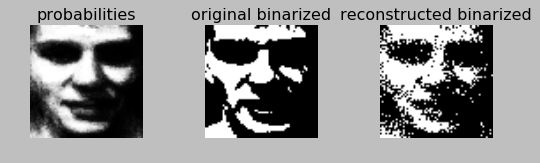

In [15]:
show_reconstruction(X_test, sampled_visible_test, probabilities_visible_test)

### Visualizing weights

Let's plot $P(v|h_i)$ for 100 $i$.

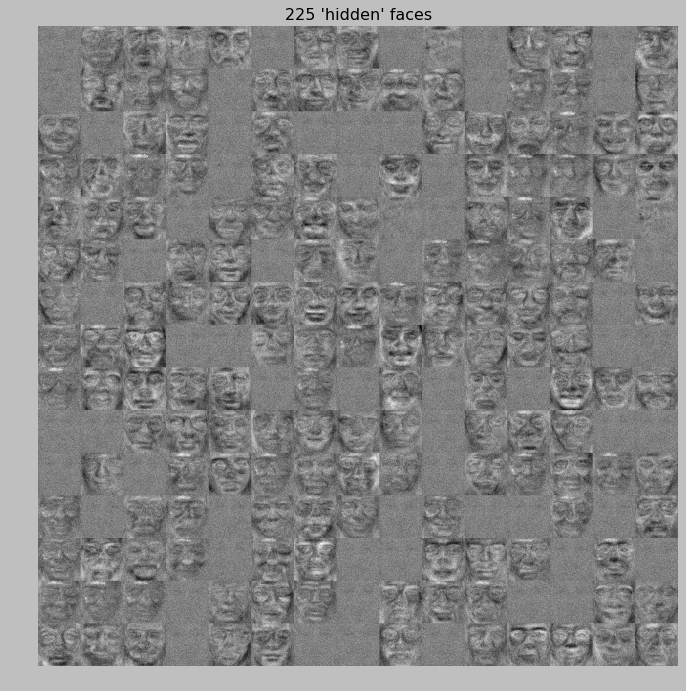

In [16]:
hidden_faces = rbm.inverse_transform(np.eye(rbm.n_hidden), use_proba=True)

plot_tiled(hidden_faces, int(np.sqrt(rbm.n_hidden)))

## Deep Belief Net

In [0]:
def fit_rbms_stack(rbms, X, n_epochs, log_n_epochs=10):
  
  train_data = X
  
  for i, rbm in enumerate(rbms):
    print('fitting {}th rbm'.format(i+1))
    %time rbm.fit(train_data, n_epochs, log_n_epochs=log_n_epochs)
    train_data = rbm.transform(train_data)
    
  return rbms

def compose_transform(transform_func, rbms, X):
  output_tmp = transform_func(rbms[0], X)
  for rbm in rbms[1:]:
    output_tmp = transform_func(rbm, output_tmp)
  return output_tmp

In [0]:
transform_func = lambda m, x: m.transform(x)
inverse_transform_func = lambda m, y: m.inverse_transform(y)

In [0]:
rbms = [RBM(225), RBM(100), RBM(50)]

In [17]:
rbms = fit_rbms_stack(rbms, X_train, n_epochs=50, log_n_epochs=50)

fitting 1th rbm
epoch 0: cd=-61.60 loss=-56.13
CPU times: user 7.88 s, sys: 1.76 s, total: 9.63 s
Wall time: 8.56 s
fitting 2th rbm
epoch 0: cd=-9.52 loss=-9.23
CPU times: user 4.74 s, sys: 444 ms, total: 5.19 s
Wall time: 3.48 s
fitting 3th rbm
epoch 0: cd=-3.18 loss=-3.05
CPU times: user 4.77 s, sys: 441 ms, total: 5.21 s
Wall time: 3.49 s


In [0]:
transform_func = lambda m, x: m.transform(x)
inverse_transform_func = lambda m, y: m.inverse_transform(y)

def compose_transform(transform_func, rbms, X):
  output_tmp = transform_func(rbms[0], X)
  for rbm in rbms[1:]:
    output_tmp = transform_func(rbm, output_tmp)
  return output_tmp

In [0]:
encoded_train = compose_transform(transform_func, rbms, X_train)